# Assignment Set 12

by **Amir Mehrpanah** for Deep Learing Course at Data Science Center, SBU

(256, 256, 3)


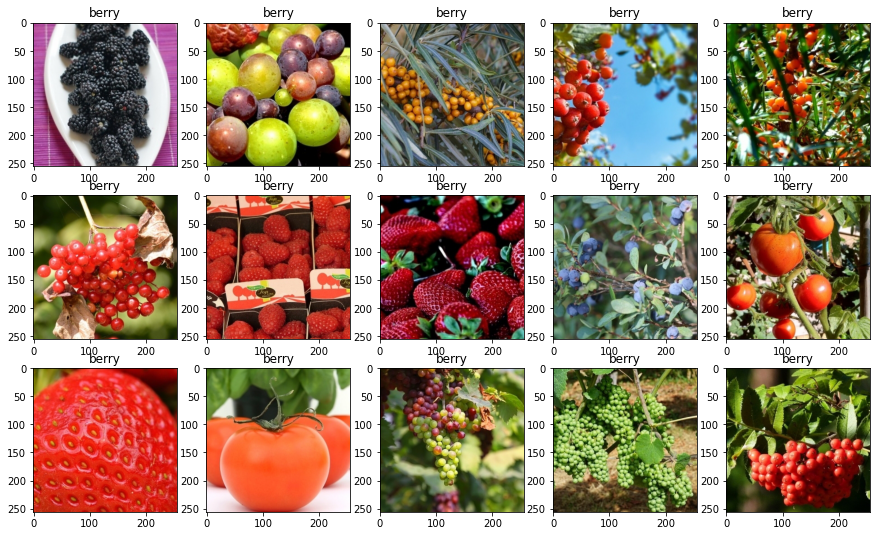

In [ ]:
root = "/kaggle/input/linnaeus-5-256x256/Linnaeus 5 256X256/"
files = glob.glob(root+'train/*/*.jpg')
fig, axes = plt.subplots(3,5, figsize=(15,9))
for i,ax in enumerate(axes.flat):
    x = plt.imread(files[i])
    y = files[i].split('/')[-2]
    ax.imshow(x)
    ax.set_title(y)
print(x.shape)        

In [ ]:
data_transform = transforms.Compose([
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

train_ds = datasets.ImageFolder(root=root+'train/',
                                           transform=data_transform)
training_generator = torch.utils.data.DataLoader(train_ds,
                                             batch_size=32, shuffle=True)

validation_ds = datasets.ImageFolder(root=root+'test/',
                                           transform=data_transform)
validation_generator = torch.utils.data.DataLoader(validation_ds,
                                             batch_size=32, shuffle=True)

In [ ]:
opt_functional = {'densenet161':lambda x:optim.Adadelta(x.parameters()),
                  'googlenet':lambda x:optim.Adadelta(x.parameters())}
loss_function = nn.CrossEntropyLoss()

In [ ]:
#@title Define Models
class GoogleNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.googlenet = models.googlenet(pretrained=True)
        self.fc1 = nn.Linear(1000, 500)
        self.fc2 = nn.Linear(500, 5)
        
    def forward(self, x):
        x = self.googlenet(x)
        x = F.relu(self.fc1(x))
        x = nn.Dropout(p=0.3)(x)   
        x = torch.softmax(self.fc2(x),dim=1)
        return x
    
class Densenet(nn.Module):
    def __init__(self):
        super().__init__()
        self.densenet161 = models.densenet161(pretrained=True)
        self.fc1 = nn.Linear(1000, 500)
        self.fc2 = nn.Linear(500, 5)
        
    def forward(self, x):
        x = self.densenet161(x)
        x = F.relu(self.fc1(x))
        x = nn.Dropout(p=0.3)(x)   
        x = torch.softmax(self.fc2(x),dim=1)
        return x

In [ ]:
max_epochs = 10

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

print(device)
torch.backends.cudnn.benchmark = True
cnn_dic = {'densenet161':Densenet(),
           'googlenet':GoogleNet()}
mdl_pool = {}
for name,cnn in cnn_dic.items():
    print('training ' + name)
    optimizer = opt_functional[name](cnn)
    cnn.to(device)
    train_epoch_loss = [] 
    train_epoch_acc = [] 
    val_epoch_loss = []
    val_epoch_acc = [] 
    for epoch in range(max_epochs):
        cnn.train()
        running_loss = []
        running_acc = []
        for local_batch, local_labels in training_generator:
            local_batch, local_labels = local_batch.to(device), local_labels.to(device)
            optimizer.zero_grad()
            outputs = cnn(local_batch)
            loss = loss_function(outputs, local_labels)
            loss.backward()
            optimizer.step()
            
            running_loss += [loss.item()]
            _, predicted = torch.max(outputs, 1)
            running_acc += [(predicted == local_labels).sum().item()/training_generator.batch_size]
        train_epoch_loss += [np.mean(running_loss)]
        train_epoch_acc += [np.mean(running_acc)]
        
        running_loss = []
        running_acc = []
        with torch.no_grad():
            cnn.eval()
            for local_batch, local_labels in validation_generator:
                local_batch, local_labels = local_batch.to(device), local_labels.to(device)
                outputs = cnn(local_batch)
                loss = loss_function(outputs, local_labels)
                running_loss += [loss.item()]
                _, predicted = torch.max(outputs, 1)
                running_acc += [(predicted == local_labels).sum().item()/validation_generator.batch_size]

        val_epoch_loss += [np.mean(running_loss)]
        val_epoch_acc += [np.mean(running_acc)]
        print('\t[{:d}] loss: {:7.5f} - acc: {:%} - val loss: {:7.5f} - val acc: {:%}'.format(epoch + 1,
                                                                                            train_epoch_loss[-1],
                                                                                            train_epoch_acc[-1],
                                                                                            val_epoch_loss[-1],
                                                                                            val_epoch_acc[-1]))
    
    mdl_pool[name]={}
    mdl_pool[name]['loss'] = train_epoch_loss
    mdl_pool[name]['acc'] = train_epoch_acc
    mdl_pool[name]['val_loss'] = val_epoch_loss
    mdl_pool[name]['val_acc'] = val_epoch_acc

cuda:0
training densenet161
	[1] loss: 1.56450 - acc: 32.529920% - val loss: 1.54502 - val acc: 33.134921%
	[2] loss: 1.52425 - acc: 36.120346% - val loss: 1.53676 - val acc: 35.466270%
	[3] loss: 1.45436 - acc: 43.550532% - val loss: 1.45793 - val acc: 43.253968%
	[4] loss: 1.47056 - acc: 42.436835% - val loss: 1.47297 - val acc: 41.716270%
	[5] loss: 1.43283 - acc: 46.675532% - val loss: 1.43298 - val acc: 46.130952%
	[6] loss: 1.43173 - acc: 46.642287% - val loss: 1.42050 - val acc: 47.668651%
	[7] loss: 1.41993 - acc: 48.005319% - val loss: 1.43987 - val acc: 45.486111%
	[8] loss: 1.39902 - acc: 50.182846% - val loss: 1.38966 - val acc: 50.843254%
	[9] loss: 1.37836 - acc: 52.127660% - val loss: 1.45704 - val acc: 44.047619%
	[10] loss: 1.41699 - acc: 48.304521% - val loss: 1.39058 - val acc: 50.496032%
training googlenet
	[1] loss: 1.37330 - acc: 52.543218% - val loss: 1.44519 - val acc: 44.841270%
	[2] loss: 1.36281 - acc: 53.706782% - val loss: 1.37649 - val acc: 52.033730%
	[3]

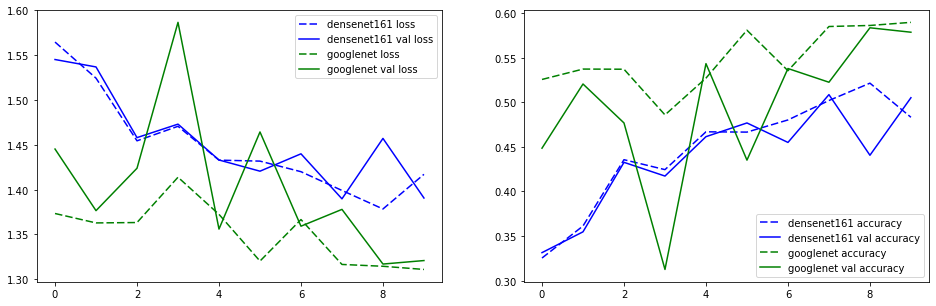

In [ ]:
#@title Plot Training History
plt.figure(figsize=(16,5))
c = ['b', 'g', 'r', 'c']
plt.subplot(121)
for i,(name,item) in enumerate(mdl_pool.items()):
    plt.plot(item['loss'],linestyle=(0,(5,2)),color=c[i],label = name+' loss')
    plt.plot(item['val_loss'],color=c[i],label = name+' val loss')
plt.legend()

plt.subplot(122)
for i,(name,item) in enumerate(mdl_pool.items()):
    plt.plot(item['acc'],linestyle=(0,(5,2)),color=c[i],label = name +' accuracy')
    plt.plot(item['val_acc'],color=c[i],label = name+' val accuracy')
plt.legend()